In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple representation space tests with an FCN


## Imports


In [25]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from typing import List
from functools import partial

import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


jax.devices()

[CpuDevice(id=0)]

In [26]:
# Make sure GPU is actually working
jnp.arange(9)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

## Load data


In [27]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass
# for c in get_true_interaction_cols(data, interaction_attr='binding_sites_idxs', remove_symmetrical=True) + get_true_interaction_cols(
#         data, interaction_attr='binding_site_group_range', remove_symmetrical=True):
#     data[c] = data[c].map(ast.literal_eval)

## Model: network of fully connected layers


In [67]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-cnn

class MLP(hk.Module):

    def __init__(self, layer_sizes: List[int], n_head: int, use_categorical: bool):
        super().__init__(name="FCN")
        self.layers = self.create_layers(layer_sizes, n_head, use_categorical)

    def create_layers(self, layer_sizes: List[int], n_head: int, use_categorical: bool):
        sizes = layer_sizes + [n_head]
        l = []
        for i, s in enumerate(sizes):
            if l:
                l.append(jax.nn.relu)
                if np.mod(i, 2) == 0:
                    l.append(jax.nn.sigmoid)
            # if sj == n_head:
            #     l.append(eqx.nn.Dropout(p=0.4))

            # He initialisation
            l.append(
                hk.Linear(s, w_init=hk.initializers.VarianceScaling(scale=2.0))
            )

        if use_categorical:
            l.append(jax.nn.log_softmax)
        return l

    def __call__(self, x: Float[Array, " num_interactions"], inference: bool = False, seed: int = 0) -> Float[Array, " n_head"]:
        for i, layer in enumerate(self.layers):
            kwargs = {} if not type(layer) == eqx.nn.Dropout else {
                'inference': inference, 'key': jax.random.PRNGKey(seed)}

            x = layer(x, **kwargs)

            if inference:
                df = pd.DataFrame(data=np.array(x), columns=['0'])
                wandb.log({f'emb_{i}_{type(layer)}': df})
        return x


def MLP_fn(x, init_kwargs: dict = {}, call_kwargs: dict = {}):
    model = MLP(**init_kwargs)
    return model(x, **call_kwargs)

## Losses


In [68]:
def loss_fn(
    params, rng,
    model: MLP, x: Float[Array, " batch n_interactions"], y: Int[Array, " batch"],
    use_l2_reg = False, l2_reg_alpha: Float = None, 
    loss_type: str = 'categorical'
) -> Float[Array, ""]:

    pred_y = model.apply(params, rng, x)
    if loss_type == 'categorical':
        loss = cross_entropy(y, pred_y, num_classes=pred_y.shape[-1]) / len(x)
    else:
        loss = mse_loss(y, pred_y.reshape(y.shape))

    # Add L2 loss
    if use_l2_reg:
        loss += sum(
            l2_loss(w, alpha=l2_reg_alpha)
            for w in jax.tree_util.tree_leaves(params)
        )
    return loss


def l2_loss(weights, alpha):
    return alpha * (weights ** 2).mean()


def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"], num_classes: int):
    one_hot_actual = jax.nn.one_hot(y, num_classes=num_classes)
    return optax.softmax_cross_entropy(pred_y, one_hot_actual).sum()


def mse_loss(y, pred_y):
    return jnp.mean(jnp.square(pred_y - y))


def update_params(optimiser, params, grads):
    updates, optimizer_state = optimiser.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params


@eqx.filter_jit
def compute_accuracy_categorical(
    params, rng, model: MLP, x: Float[Array, "batch num_interactions"], y: Int[Array, " batch n_head"]
) -> Float[Array, ""]:
    pred_y = model.apply(params, rng, x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


@eqx.filter_jit
def compute_accuracy_regression(
    params, rng, model: MLP, x: Float[Array, "batch num_interactions"], y: Int[Array, " batch n_head"],
    threshold = 0.1
) -> Float[Array, ""]:
    pred_y = model.apply(params, rng, x)
    return jnp.mean(jnp.abs(y - pred_y) <= threshold)

## Hyperparameters


In [69]:
BATCH_SIZE = 128
N_BATCHES = 1000
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
train_split_perc = 0.8
TRAIN_SPLIT = int(train_split_perc * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 500
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity'

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = True
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = 'dual_'
save_path = 'saves_' + subtask + str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_')

rng = jax.random.PRNGKey(SEED)

## Initialise


### Input

To make sure that there is little repetition in the dataset, the uniqueness of each sample will be judged. For genetic circuits,there is a lot of sparsity, as most biological sequences do not interact. Therefore, there may be an overrepresentation of some circuit topologies.


In [70]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


def drop_duplicates_keep_first_n(df, column, n):
    """ GCG """
    indices = df[df.duplicated(subset=column, keep=False)].groupby(
        column).head(n).index
    all_duplicates_indices = df[df.duplicated(subset=column, keep=False)].index
    to_drop = list(set(all_duplicates_indices) - set(indices))
    df2 = df.drop(to_drop)
    return df2


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=200)
df['sensitivity_wrt_species-6'] = df['sensitivity_wrt_species-6'].round(
    np.abs(int(f'{df["sensitivity_wrt_species-6"].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column='sensitivity_wrt_species-6', n=200)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])

In [71]:
TOTAL_DS

64000

In [72]:
# Taken from synbio_morpher/explanations/data_enhancing
k = 'energies'
df[[f'{i}_diffs' for i in get_true_interaction_cols(data, k, remove_symmetrical=True)]] = df.groupby(
    ['circuit_name'])[get_true_interaction_cols(data, k, remove_symmetrical=True)].apply(lambda x: x - x.iloc[0]).to_numpy()

In [73]:
x = df[get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True) + [f'{i}_diffs' for i in get_true_interaction_cols(data, k, remove_symmetrical=True)]
].iloc[:TOTAL_DS].values
y_cols = ['sensitivity_wrt_species-6',
        'sensitivity_wrt_species-6_ratio_from_mutation_to_base']
y = df[y_cols].iloc[:TOTAL_DS].to_numpy()


if USE_CATEGORICAL:
    y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    y_map[-6] = 1
    y_map[-5] = 1
    y_map[-4] = 4
    y_map[-3] = 2
    y_map[-1] = 3
    y = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
    y = np.interp(y, sorted(np.unique(y)), np.arange(
        len(sorted(np.unique(y))))).astype(int)
else:
    zero_log_replacement = -10.0
    y = np.where(y != 0, np.log10(y), zero_log_replacement)

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else len(y_cols)


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

#### Scale input


In [74]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = xscaler.inverse_transform(normalized)

# xscaler, yscaler = StandardScaler(), StandardScaler()
# x = xscaler.fit_transform(x)
# y = yscaler.fit_transform(y)
# inverse = scaler.inverse_transform(standardized)

In [75]:
x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

In [76]:
y.shape

(64000, 2)

Text(0.5, 1.0, 'y sensitivity ratio')

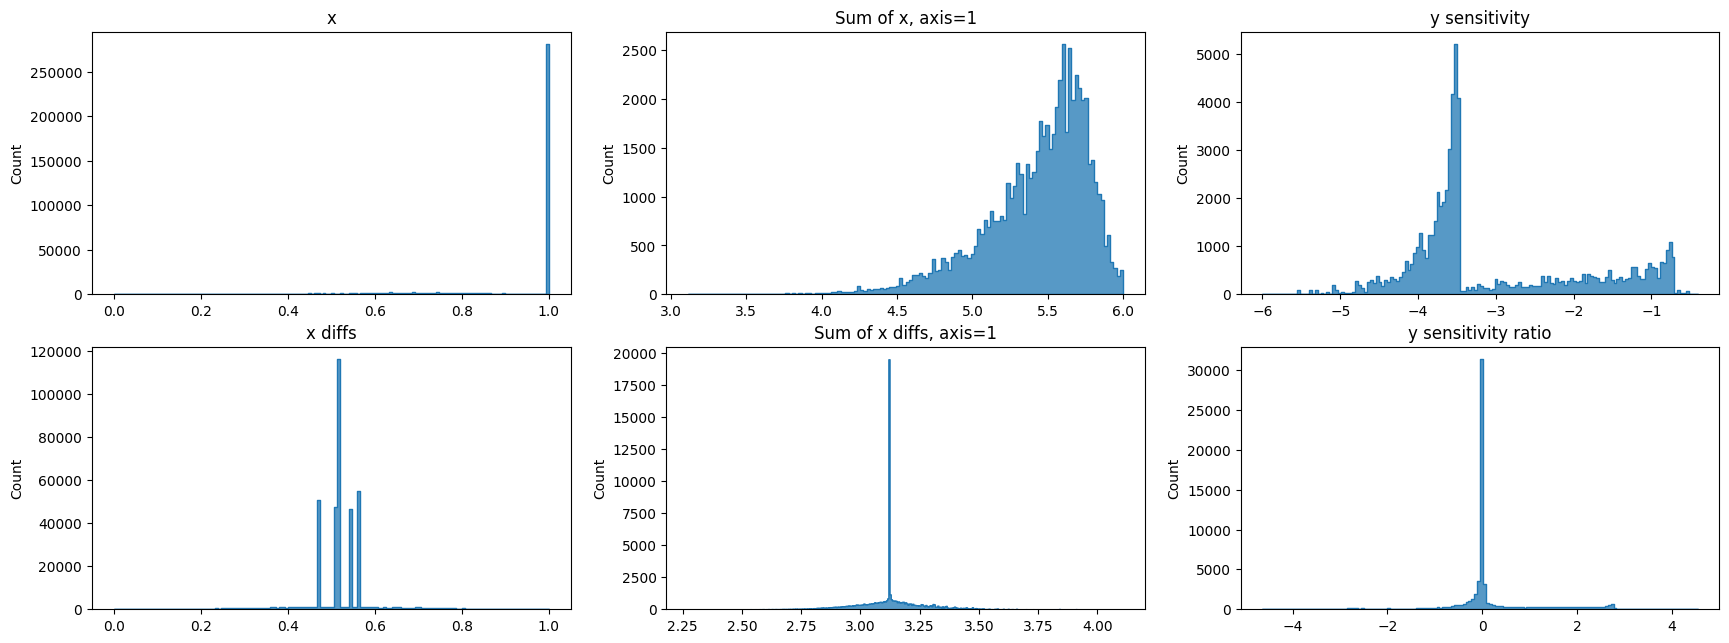

In [77]:
plt.figure(figsize=(3*7, 5 * 1.5))
ax = plt.subplot(2, 3, 1)
sns.histplot(x=x[:, :6].flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(2, 3, 2)
sns.histplot(x=np.sum(x[:, :6], axis=1).flatten(), element='step')
plt.title('Sum of x, axis=1')
ax = plt.subplot(2, 3, 3)
sns.histplot(x=(y[:, 0].flatten()), element='step', bins=150)
plt.title('y sensitivity')

ax = plt.subplot(2, 3, 4)
sns.histplot(x=x[:, 6:].flatten(), element='step', bins=150, log_scale=[False, False])
plt.title('x diffs')
ax = plt.subplot(2, 3, 5)
sns.histplot(x=np.sum(x[:, 6:], axis=1).flatten(), element='step', log_scale=[False, False])
plt.title('Sum of x diffs, axis=1')
ax = plt.subplot(2, 3, 6)
sns.histplot(x=(y[:, 1].flatten()), element='step', bins=150, log_scale=[False, False])
plt.title('y sensitivity ratio')

In [78]:

# Calculate the sparsity of the dataset
num_zeros = (x == 0).sum()
total_elements = np.size(x)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset x: {sparsity:.4f}")

num_zeros = (y == 0).sum()
total_elements = np.size(y)
sparsity = num_zeros / total_elements

print(f"The sparsity of the dataset y: {sparsity:.4f}")

The sparsity of the dataset x: 0.0000
The sparsity of the dataset y: 0.1161


Text(0.5, 1.0, 'y')

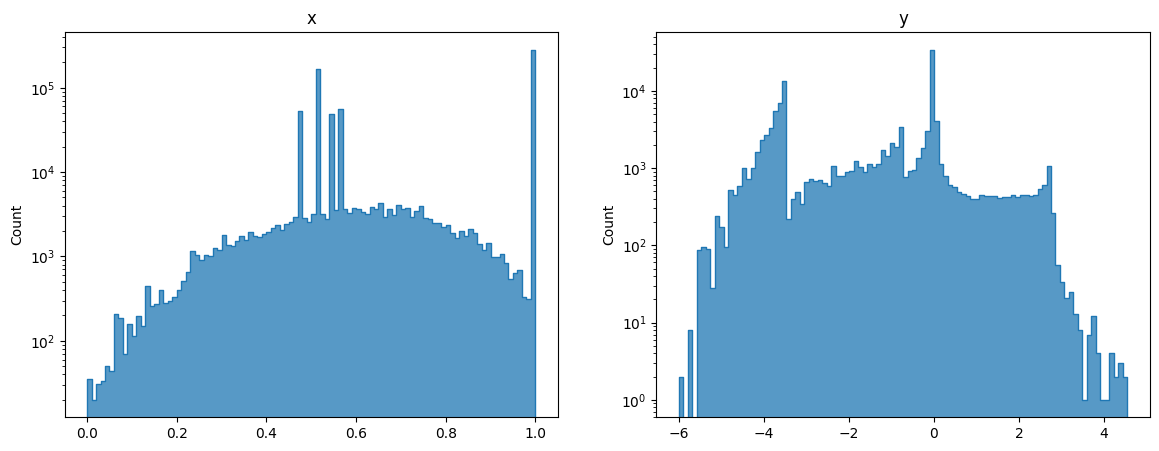

In [79]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(x=x.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('x')
ax = plt.subplot(1, 2, 2)
sns.histplot(x=y.flatten(), element='step', log_scale=[False, True], bins=100)
plt.title('y')

### Initialise WandB 


In [80]:

wandb.init(
    # set the wandb project where this run will be logged
    project="mlp-encoder_decoder",
    # track hyperparameters and run metadata
    config={
        "architecture": "MLP_dual",
        "dataset": "Circuits",
        "epochs": EPOCHS,
        "input_species": INPUT_SPECIES,
        "layer_sizes": LAYER_SIZES,
        "learning_rate": LEARNING_RATE,
        "learning_rate_schedule": LEARNING_RATE_SCHED,
        "n_head": N_HEAD,
        "seed": SEED,
        "target_circuit_function": target_circ_func,
        "total_dataset_size": TOTAL_DS,
        "train_split_percentage": train_split_perc,
        "use_categorical": USE_CATEGORICAL,
        "use_dropout": USE_DROPOUT,
        "use_L2_reg": USE_L2_REG,
        "use_warmup": USE_WARMUP,
        "warmup_epochs": WARMUP_EPOCHS
    }
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### Initialise model


In [81]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Text(0.5, 0.98, 'Initial weight distribution')

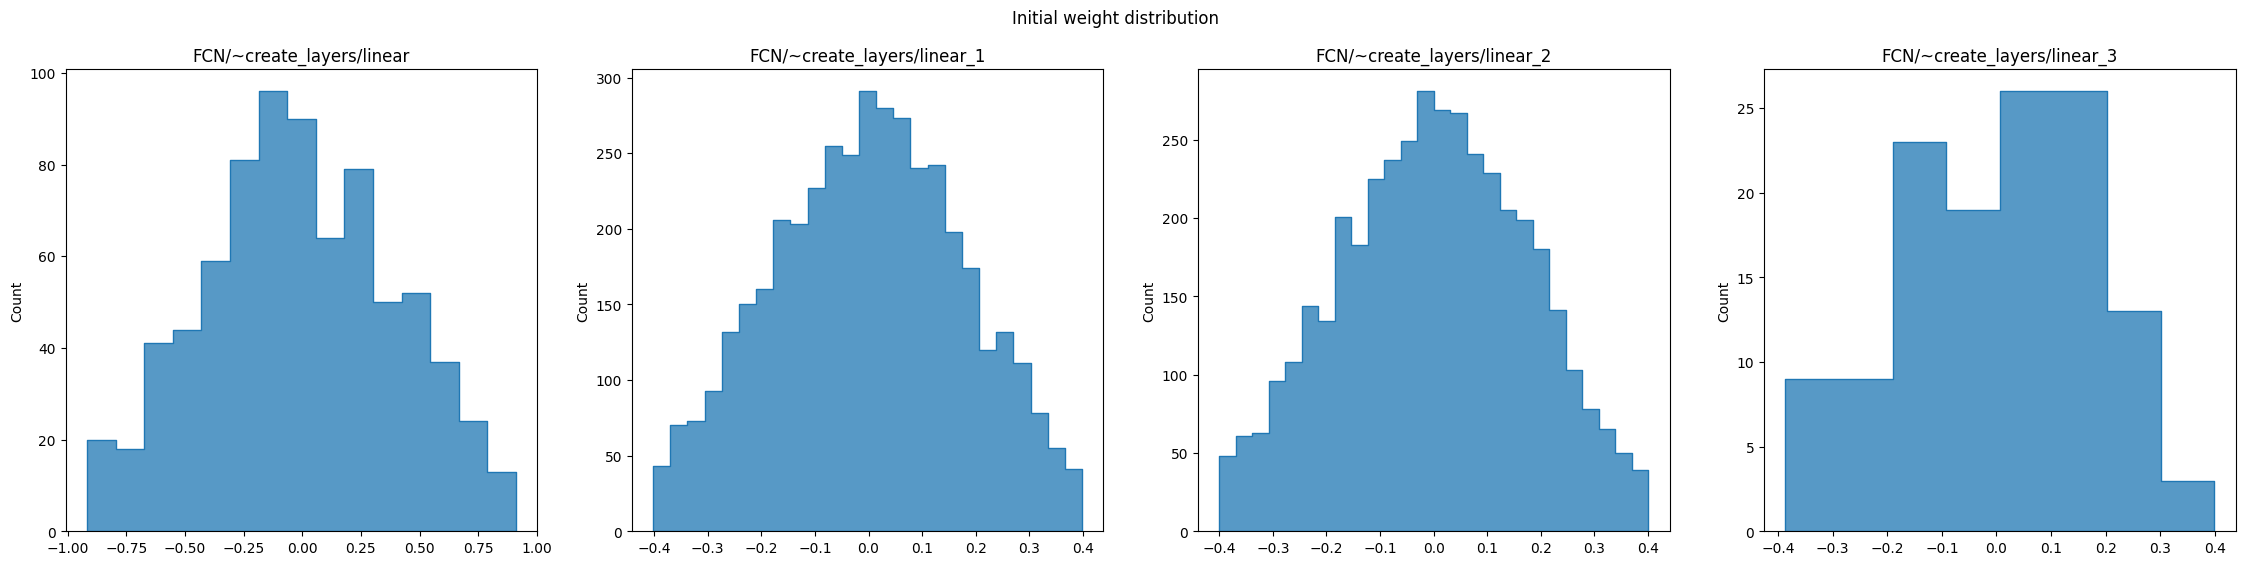

In [82]:
plt.figure(figsize=(7*len(params), 6))
for i in range(len(params)):
    ax = plt.subplot(1, len(params), i+1)
    sns.histplot(params[list(params.keys())[i]]['w'].flatten(), element='step')
    plt.title(list(params.keys())[i])
plt.suptitle('Initial weight distribution')

### Optimiser


In [83]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

## Train


In [84]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
            
    return params, saves

In [92]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      save_every=PRINT_EVERY)  # int(STEPS // 15))

Epoch 0 / 10 -		 Train loss: 0.7415749430656433	Val loss: 0.8356027603149414	Val accuracy: 0.05425781011581421
Epoch 1 / 10 -		 Train loss: 0.715074360370636	Val loss: 0.808437705039978	Val accuracy: 0.06453125178813934
Epoch 2 / 10 -		 Train loss: 0.6878100037574768	Val loss: 0.7801794409751892	Val accuracy: 0.0830078125
Epoch 3 / 10 -		 Train loss: 0.6594390869140625	Val loss: 0.7506316304206848	Val accuracy: 0.10011718422174454
Epoch 4 / 10 -		 Train loss: 0.6298192739486694	Val loss: 0.7197158932685852	Val accuracy: 0.11683593690395355
Epoch 5 / 10 -		 Train loss: 0.5991621613502502	Val loss: 0.6876165270805359	Val accuracy: 0.1293359398841858
Epoch 6 / 10 -		 Train loss: 0.5677970051765442	Val loss: 0.6545996069908142	Val accuracy: 0.13933593034744263
Epoch 7 / 10 -		 Train loss: 0.536299467086792	Val loss: 0.6211057305335999	Val accuracy: 0.1450781226158142
Epoch 8 / 10 -		 Train loss: 0.5037661790847778	Val loss: 0.5859666466712952	Val accuracy: 0.1506640613079071
Epoch 9 / 10 -

## Visualise


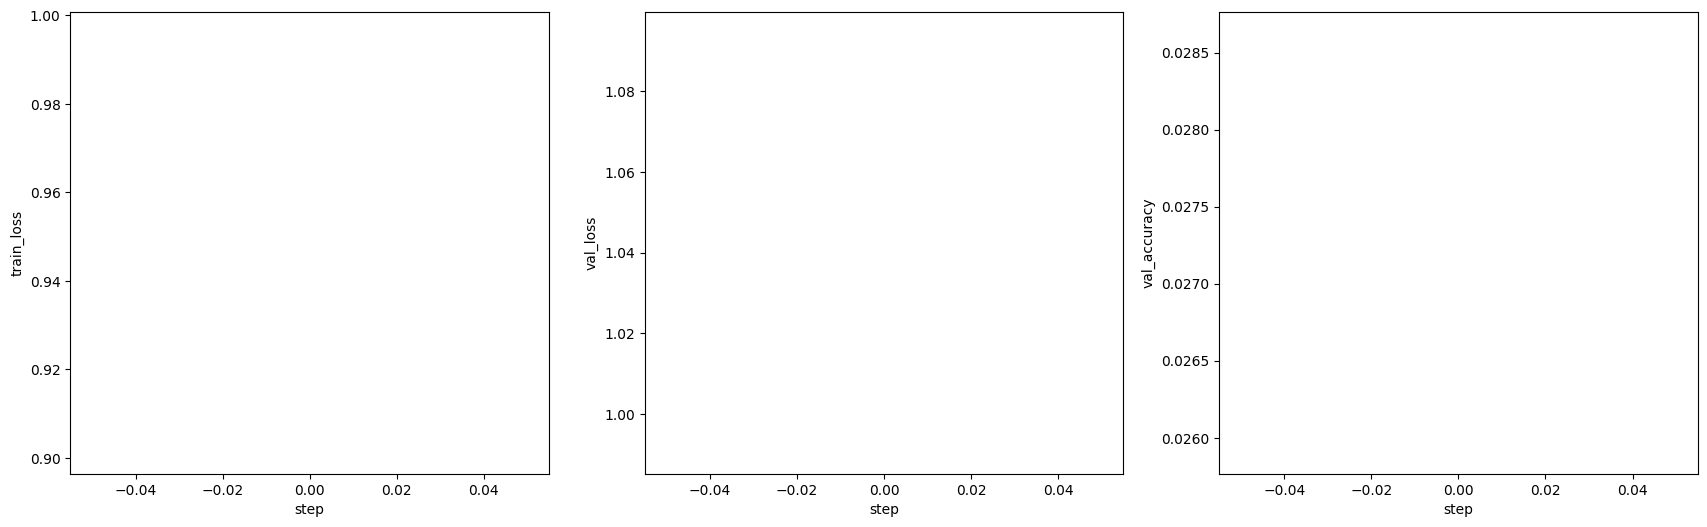

In [89]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.savefig('training_summary.png')

The R2 score is  0.17451165096150534
The R2 score with weighted variance is  0.2013016880814525


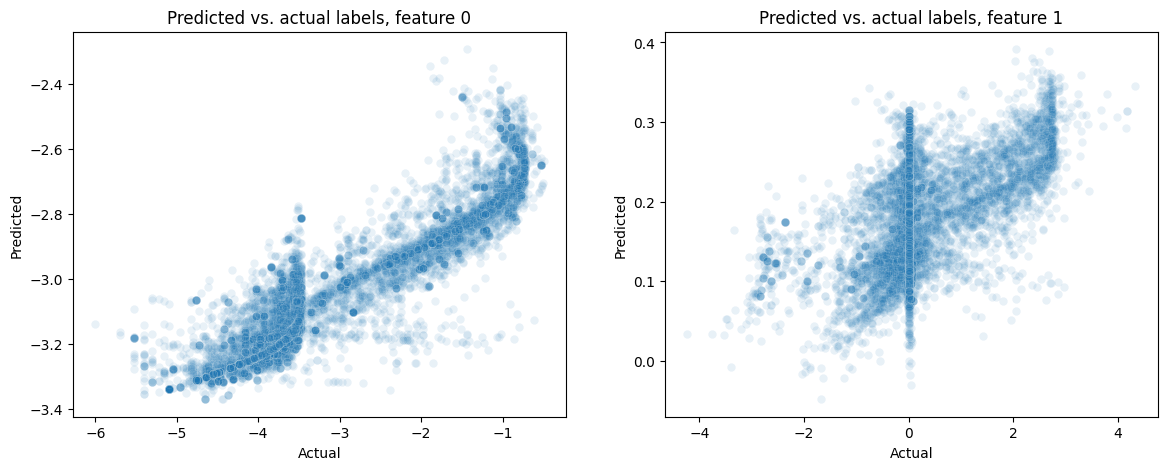

In [91]:
# params = arrayise(params)
predicted = model.apply(params, rng, x_val)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

plt.figure(figsize=(7*y_val.shape[-1], 5))
for i in range(y_val.shape[-1]):
    ax = plt.subplot(1, y_val.shape[-1], i+1)
    sns.scatterplot(x=y_val[:, i], y=predicted[:, i], alpha=0.1)
    plt.title(f'Predicted vs. actual labels, feature {i}')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')

print('The R2 score is ', r2_score(y_val, predicted))
print('The R2 score with weighted variance is ', r2_score(
    y_val, predicted, multioutput='variance_weighted'))

In [93]:
# saves_grads = [v['grads'] for v in saves.values()]

# plt.figure(figsize=(6*7, 20*6))
# i = 1
# layer_to_visualise = list(saves_grads[0].keys())[2]
# for s in saves_grads:
#     for v in [s[layer_to_visualise]]:
#         ax = plt.subplot(len(saves_grads), 4, i)
#         plt.imshow(v['w'])
#         plt.title(i)
#         i += 1
# plt.suptitle(f'Grads: {layer_to_visualise}')

Text(0.5, 0.98, 'Param weights: FCN/~create_layers/linear_2')

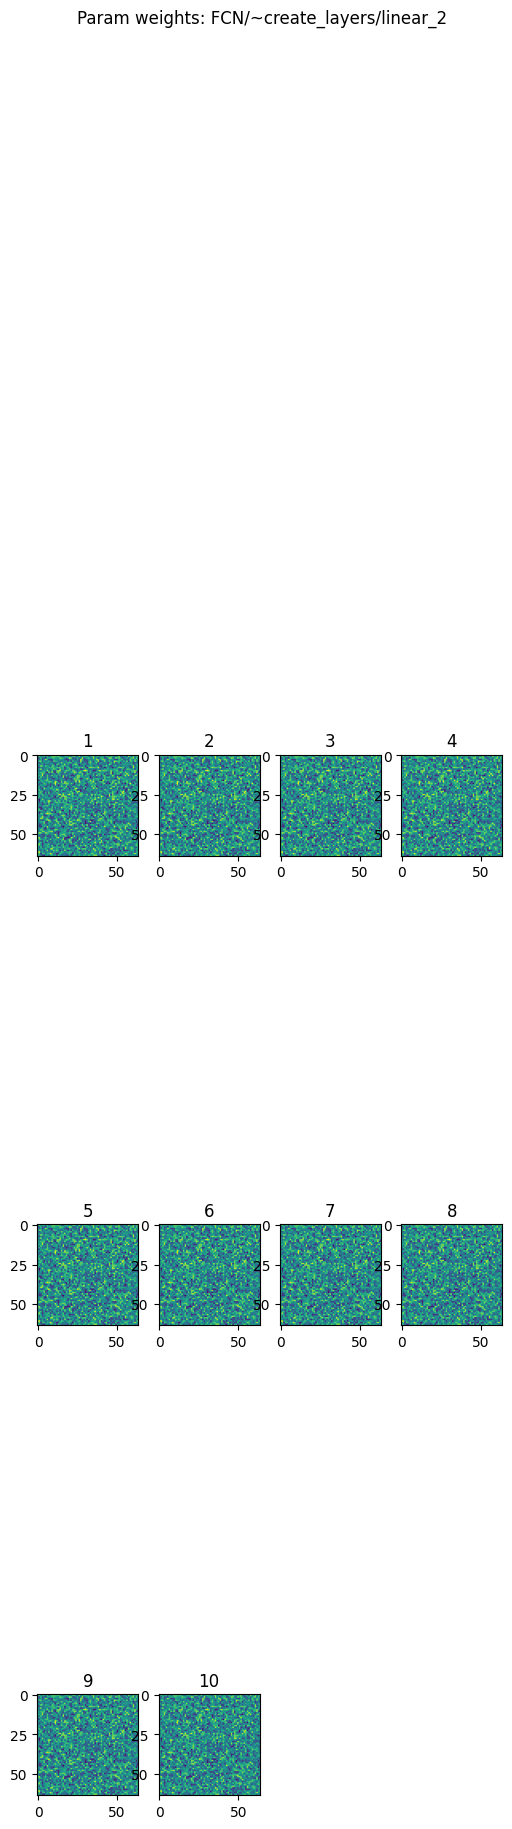

In [94]:
saves_params = [v['params'] for v in saves.values()]

plt.figure(figsize=(6*1, 10*6))
i = 1
layer_to_visualise = list(saves_params[0].keys())[2]
for s in saves_params:
    for v in [s[layer_to_visualise]]:
        ax = plt.subplot(len(saves_params), 4, i)
        plt.imshow(v['w'])
        plt.title(i)
        i += 1
plt.suptitle(f'Param weights: {layer_to_visualise}')

In [95]:
write_json(saves, out_path=save_path)

## Examine trained model


In [96]:
# saves_loaded = load_json_as_dict('saves')
# saves_loaded = load_json_as_dict('saves_20231016')
# saves_loaded = load_json_as_dict('saves_20231019')
saves_loaded = load_json_as_dict(save_path)


def arrayise(d):
    for k, v in d.items():
        if type(v) == dict:
            for kk, vv in v.items():
                d[k][kk] = jnp.array(vv)
    return d


step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

i = 0
pred_y = model.apply(p, rng, x[i], call_kwargs={'inference': True})

pred_y.shape

(2,)

In [97]:
pred_y = model.apply(p, rng, x)
if USE_CATEGORICAL:
    pred_y = jnp.argmax(pred_y, axis=1)
saves_loaded.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

The R2 score is  0.4365030294839403
The R2 score with weighted variance is  0.4946272640606654


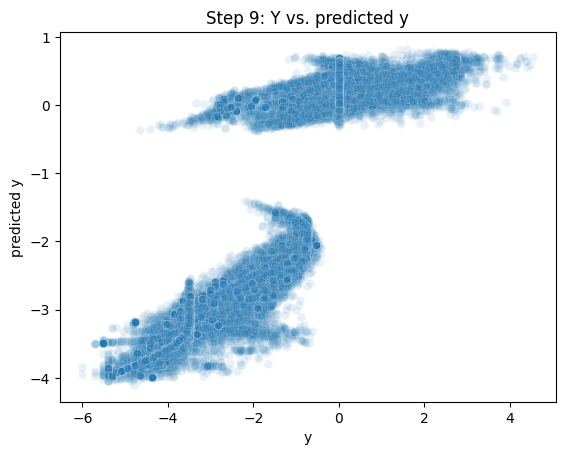

In [98]:
sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
plt.title(f'Step {step}: Y vs. predicted y')
plt.xlabel('y')
plt.ylabel('predicted y')

print('The R2 score is ', r2_score(y, pred_y))
print('The R2 score with weighted variance is ', r2_score(
    y, pred_y, multioutput='variance_weighted'))

In [99]:


# rows = int(np.ceil(np.sqrt(len(saves_loaded))))
# cols = int(np.ceil(np.sqrt(len(saves_loaded))))

# fig = plt.figure(figsize=(7*cols, 6*rows))
# for i, (step, v) in enumerate(saves_loaded.items()):
#     p = v['params']
#     p = arrayise(p)

#     pred_y = model.apply(p, rng, x)

#     ax = plt.subplot(rows, cols, i+1)
#     sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1)
#     plt.title(f'Step {step}: Y vs. predicted y')
#     plt.xlabel('y')
#     plt.ylabel('predicted y')

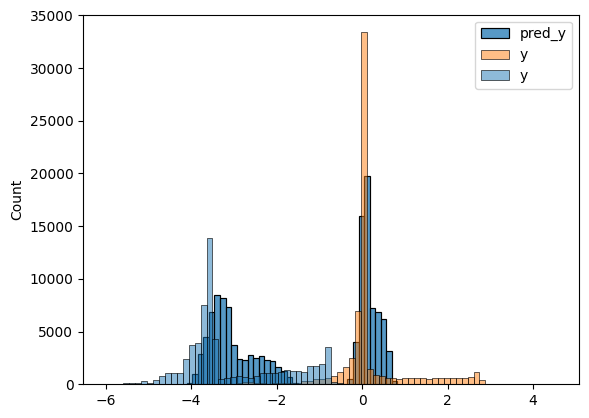

In [100]:

sns.histplot(pred_y.flatten(), label='pred_y')
sns.histplot(y, label='y')
plt.legend()

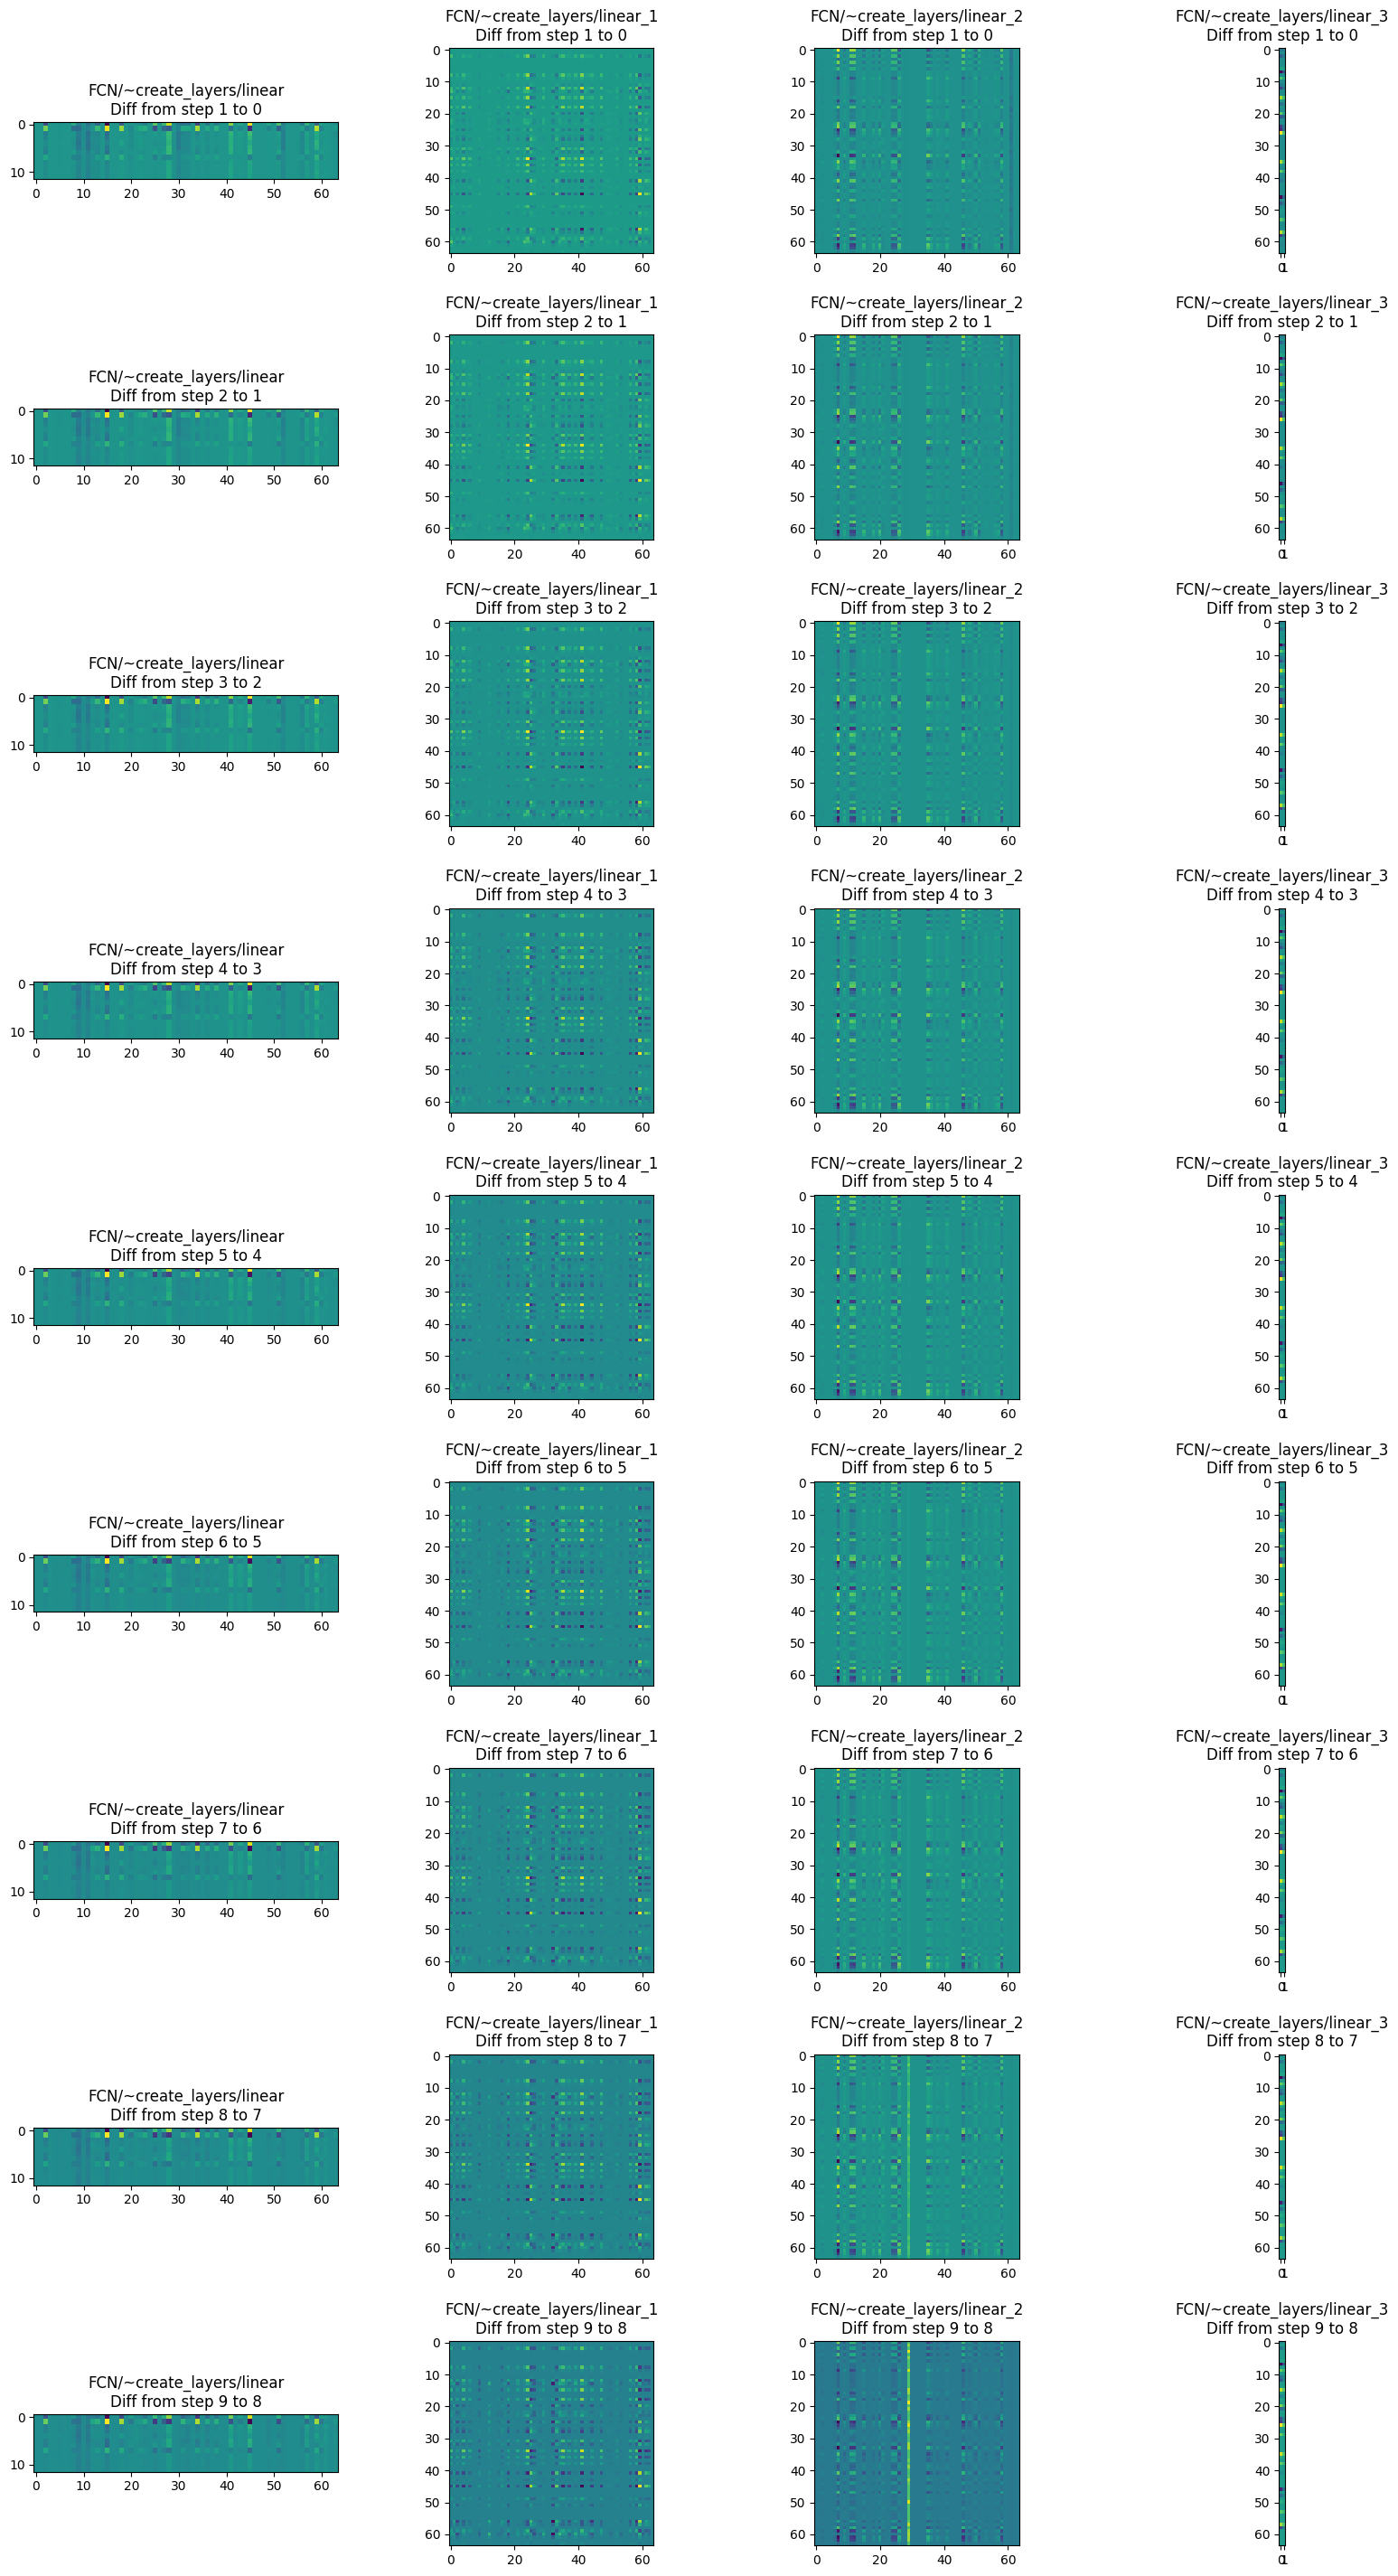

In [101]:

rows = len(saves_loaded.keys())
cols = len(p)
fig = plt.figure(figsize=(5*cols, 4*rows))
fig.subplots_adjust(hspace=0.4)
i = 0
diff_min = 0
diff_max = 0
for k0, k1 in zip(list(saves_loaded.keys())[:-1], list(saves_loaded.keys())[1:]):
    p0 = saves_loaded[k0]['params']
    p0 = arrayise(p0)
    p = saves_loaded[k1]['params']
    p = arrayise(p)

    for k, v0, v in zip(p0.keys(), p0.values(), p.values()):
        diff = v['w'] - v0['w']
        diff_min = np.min([diff_min, diff.min()])
        diff_max = np.max([diff_max, diff.max()])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(diff)
        # plt.imshow(v['w'])
        # plt.clim(diff_min, diff_max)
        i += 1
        plt.title(f'{k}\nDiff from step {k1} to {k0}')

### TSNE


In [103]:
step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x_val)

In [104]:
x_og_val = xscaler.inverse_transform(x_val)

try:
    cols = list(map(str, np.arange(x.shape[-1])))
    df1 = pd.DataFrame(data=x_og_val, columns=cols)
    # df1['image'] = df1.apply(lambda row: wandb.Image(row.values.reshape(1, x_og_val.shape[-1])), axis=1)
    if USE_CATEGORICAL:
        df1['Predicted Sensitivity'] = np.argmax(pred_y, axis=1)
    else:
        df1['Predicted Sensitivity'] = pred_y[:, 0]
        df1['Predicted Sensitivity ratio from mutation to base'] = pred_y[:, 1]
    df1['Actual Sensitivity'] = y_val[:, 0]
    df1['Actual Sensitivity ratio from mutation to base'] = y_val[:, 1]
    df1['interacting'] = [str(np.round(i, 2)) for i in list(x_og_val[:, :6])]
    df1['interacting diffs'] = [str(np.round(i, 2)) for i in list(x_og_val[:, 6:])]
    df1['zeros_idxs'] = [''.join([str(ii) for ii in np.argwhere(
        i == 0).tolist()]).replace('[', '').replace(']', '') for i in list(x_og_val[:, :6])]
    # df1['target'] = df1['target'].apply(str)
    # df1 = df1[df1.columns.tolist()[-2:] + df1.columns.tolist()[:-2]]

    wandb.log({"digits": df1})
except:
    print('nah')
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
